# Multi-Domain Review Classification: Dataset Construction and Model Evaluation

1. Overview

This notebook builds and evaluates a multi-domain text classification dataset constructed from three popular sources:

- SST-2 (movie reviews)

- Yelp Review Dataset (local business reviews)

- Amazon Reviews (online shopping reviews)

Our goal is to classify each comment into its domain category, rather than predicting sentiment.
This represents a domain identification task, where a model must learn the stylistic and linguistic differences across datasets.

2. Motivation

Different review domains exhibit distinct writing patterns:

- Movie reviews often contain emotional or narrative descriptions.

- Yelp reviews frequently describe service, environment, or dining experience.

- Amazon reviews generally reference product quality or shipping details.

Understanding whether models can distinguish these domains helps assess:

- Generalization ability across datasets

- Robustness to stylistic variation

- Architectural differences (Baseline Transformer vs. Recurrent Transformer)

In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import time
import os
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [1]:
# Model configurations
BASELINE_CONFIG = {
    'hidden_size': 384,
    'num_hidden_layers': 6,
    'num_attention_heads': 6,
    'intermediate_size': 1536,
    'dropout_prob': 0.1,
    'use_flash_attention': True,
    'use_swiglu': True,
    'use_rope': True,
    'use_rms_norm': True
}

RECURRENT_CONFIG = {
    'hidden_size': 256,
    'num_hidden_layers': 3,
    'recurrent_depth': 2,  # Effective depth: 3 × 2 = 6
    'num_attention_heads': 4,
    'intermediate_size': 1024,
    'dropout_prob': 0.1,
    'residual_scale': 0.5,
    'use_flash_attention': True,
    'use_swiglu': True,
    'use_rope': True,
    'use_rms_norm': True
}

TRAINING_CONFIG = {
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 3e-5,
    'warmup_steps': 100,
    'eval_steps': 50,
    'max_length': 128
}


In [2]:
# Load data
from training.utils import prepare_multi_domain_data, load_tokenizer

tokenizer = load_tokenizer('bert-base-uncased')

train_loader, val_loader, test_loader = prepare_multi_domain_data(
    data_dir='data/multi',   # multi_train.pkl, multi_internal_val.pkl, multi_val.pkl 所在目录
    tokenizer=tokenizer,
    batch_size=TRAINING_CONFIG['batch_size'],
    max_length=TRAINING_CONFIG['max_length']
)

train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)

print(f"Dataset sizes - Train: {train_size}, Validation: {val_size}")


Loaded 54576 multi-domain samples from data/multi\multi_train.pkl
Loaded 6822 multi-domain samples from data/multi\multi_val.pkl
Loaded 6822 multi-domain samples from data/multi\multi_test.pkl
Dataset sizes - Train: 54576, Validation: 6822


In [9]:
# Initialize models
from models.baseline import BaselineModel, BaselineConfig
from models.recurrent import RecurrentModel, RecurrentConfig

# Baseline model
baseline_config = BaselineConfig(
    vocab_size=30522,
    hidden_size=BASELINE_CONFIG['hidden_size'],
    num_hidden_layers=BASELINE_CONFIG['num_hidden_layers'],
    num_attention_heads=BASELINE_CONFIG['num_attention_heads'],
    intermediate_size=BASELINE_CONFIG['intermediate_size'],
    hidden_dropout_prob=BASELINE_CONFIG['dropout_prob'],
    attention_probs_dropout_prob=BASELINE_CONFIG['dropout_prob'],
    num_labels=3,
    **{k: v for k, v in BASELINE_CONFIG.items() if k.startswith('use_')}
)

# Recurrent model
recurrent_config = RecurrentConfig(
    vocab_size=30522,
    hidden_size=RECURRENT_CONFIG['hidden_size'],
    num_hidden_layers=RECURRENT_CONFIG['num_hidden_layers'],
    recurrent_depth=RECURRENT_CONFIG['recurrent_depth'],
    num_attention_heads=RECURRENT_CONFIG['num_attention_heads'],
    intermediate_size=RECURRENT_CONFIG['intermediate_size'],
    hidden_dropout_prob=RECURRENT_CONFIG['dropout_prob'],
    attention_probs_dropout_prob=RECURRENT_CONFIG['dropout_prob'],
    residual_scale=RECURRENT_CONFIG['residual_scale'],
    num_labels=3,
    **{k: v for k, v in RECURRENT_CONFIG.items() if k.startswith('use_')}
)

baseline_model = BaselineModel(baseline_config).to(device)
recurrent_model = RecurrentModel(recurrent_config).to(device)

# Model statistics
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

baseline_params = count_parameters(baseline_model)
recurrent_params = count_parameters(recurrent_model)

print(f"Baseline: {baseline_params:,} parameters ({baseline_params/1e6:.1f}M)")
print(f"Recurrent: {recurrent_params:,} parameters ({recurrent_params/1e6:.1f}M)")
print(f"Parameter reduction: {(1 - recurrent_params/baseline_params)*100:.1f}%")


Baseline: 25,913,091 parameters (25.9M)
Recurrent: 10,972,419 parameters (11.0M)
Parameter reduction: 57.7%


In [10]:
# Train both models with early stopping
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import copy
import torch

def train_model(model, name, num_epochs=TRAINING_CONFIG['num_epochs'], patience=3, min_delta=0.001):
    optimizer = AdamW(model.parameters(), lr=TRAINING_CONFIG['learning_rate'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_losses = []

        for batch in tqdm(train_loader, desc=f"{name} Epoch {epoch+1}/{num_epochs}", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()

            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )

            loss = outputs['loss']
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_losses = []
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    labels=batch['labels']
                )

                val_losses.append(outputs['loss'].item())
                predictions = outputs['logits'].argmax(dim=-1)
                val_correct += (predictions == batch['labels']).sum().item()
                val_total += batch['labels'].size(0)

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        val_acc = val_correct / val_total
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0

            print(f"{name} Epoch {epoch+1}: Train_Loss={train_loss:.4f}, Val_Loss={val_loss:.4f}, Acc={val_acc:.4f} *")

            # Save best model at this moment
            save_path = f"{name}_best_model.pt"
            torch.save(best_model_state, save_path)
            # print(f"{name}: Saved new best model → {save_path}")   # Optional log

        else:
            patience_counter += 1
            print(f"{name} Epoch {epoch+1}: Train_Loss={train_loss:.4f}, Val_Loss={val_loss:.4f}, Acc={val_acc:.4f}")

        if patience_counter >= patience:
            print(f"{name}: Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"{name}: Loaded best model with val_loss={best_val_loss:.4f}")

    return history

# Train models
print("Training with early stopping (patience=3)")
print("-" * 50)
baseline_history = train_model(baseline_model, "Baseline")
print()
recurrent_history = train_model(recurrent_model, "Recurrent")


Training with early stopping (patience=3)
--------------------------------------------------


Baseline Epoch 1: Train_Loss=0.1655, Val_Loss=0.0735, Acc=0.9839 *


Baseline Epoch 2: Train_Loss=0.0664, Val_Loss=0.0714, Acc=0.9849 *


Baseline Epoch 3: Train_Loss=0.0438, Val_Loss=0.1334, Acc=0.9801


Baseline Epoch 4: Train_Loss=0.0272, Val_Loss=0.1313, Acc=0.9824


Baseline Epoch 5: Train_Loss=0.0184, Val_Loss=0.1228, Acc=0.9846
Baseline: Early stopping triggered at epoch 5
Baseline: Loaded best model with val_loss=0.0714



Recurrent Epoch 1: Train_Loss=0.1752, Val_Loss=0.1215, Acc=0.9783 *


Recurrent Epoch 2: Train_Loss=0.0662, Val_Loss=0.0740, Acc=0.9856 *


Recurrent Epoch 3: Train_Loss=0.0418, Val_Loss=0.0861, Acc=0.9858


Recurrent Epoch 4: Train_Loss=0.0296, Val_Loss=0.1154, Acc=0.9814


Recurrent Epoch 5: Train_Loss=0.0215, Val_Loss=0.0913, Acc=0.9848
Recurrent: Early stopping triggered at epoch 5
Recurrent: Loaded best model with val_loss=0.0740


In [12]:
# Evaluate models
def evaluate_model(model, loader):
    model.eval()

    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    inference_times = []

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            # Measure inference time
            start_time = time.time()
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            inference_times.append((time.time() - start_time) * 1000 / batch['input_ids'].size(0))

            predictions = outputs['logits'].argmax(dim=-1)
            total_correct += (predictions == batch['labels']).sum().item()
            total_samples += batch['labels'].size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    accuracy = total_correct / total_samples
    avg_inference_time = np.mean(inference_times)

    # ---- Multiclass metrics (macro) ----
    from sklearn.metrics import f1_score, precision_score, recall_score

    f1 = f1_score(all_labels, all_predictions, average="macro")
    precision = precision_score(all_labels, all_predictions, average="macro")
    recall = recall_score(all_labels, all_predictions, average="macro")

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'inference_time_ms': avg_inference_time,
        'y_true': all_labels,
        'y_pred': all_predictions
    }


# Evaluate on test set
baseline_metrics = evaluate_model(baseline_model, test_loader)
recurrent_metrics = evaluate_model(recurrent_model, test_loader)

# Model sizes
baseline_size_mb = baseline_params * 4 / (1024 * 1024)  # 4 bytes per parameter
recurrent_size_mb = recurrent_params * 4 / (1024 * 1024)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Recurrent'],
    'Parameters': [baseline_params, recurrent_params],
    'Size (MB)': [baseline_size_mb, recurrent_size_mb],
    'Accuracy': [baseline_metrics['accuracy'], recurrent_metrics['accuracy']],
    'F1': [baseline_metrics['f1'], recurrent_metrics['f1']],
    'Precision': [baseline_metrics['precision'], recurrent_metrics['precision']],
    'Recall': [baseline_metrics['recall'], recurrent_metrics['recall']],
    'Inference (ms)': [baseline_metrics['inference_time_ms'], recurrent_metrics['inference_time_ms']]
})

print(comparison_df.round(4))


       Model  Parameters  Size (MB)  Accuracy      F1  Precision  Recall  \
0   Baseline    25913091    98.8506    0.9840  0.9840     0.9841  0.9840   
1  Recurrent    10972419    41.8565    0.9865  0.9865     0.9865  0.9865   

   Inference (ms)  
0          0.3304  
1          0.3228  


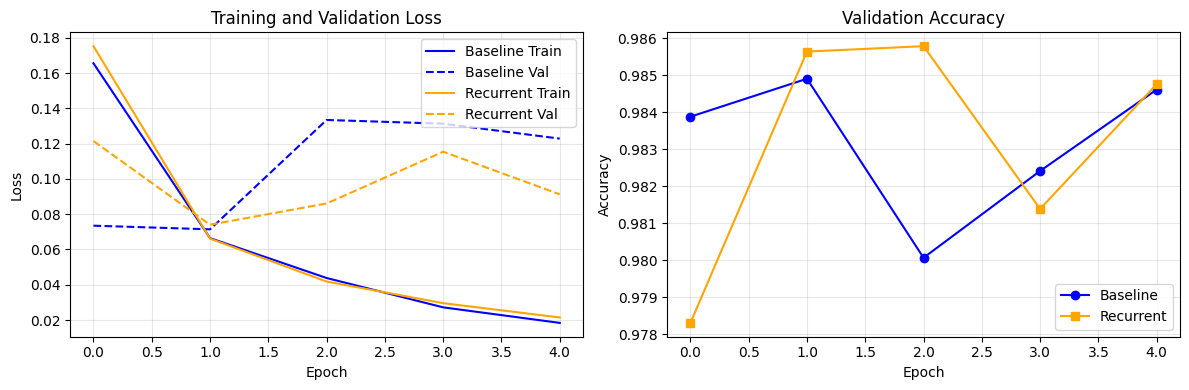

In [13]:
# Training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
axes[0].plot(baseline_history['train_loss'], label='Baseline Train', color='blue', linestyle='-')
axes[0].plot(baseline_history['val_loss'], label='Baseline Val', color='blue', linestyle='--')
axes[0].plot(recurrent_history['train_loss'], label='Recurrent Train', color='orange', linestyle='-')
axes[0].plot(recurrent_history['val_loss'], label='Recurrent Val', color='orange', linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(baseline_history['val_acc'], label='Baseline', color='blue', marker='o')
axes[1].plot(recurrent_history['val_acc'], label='Recurrent', color='orange', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


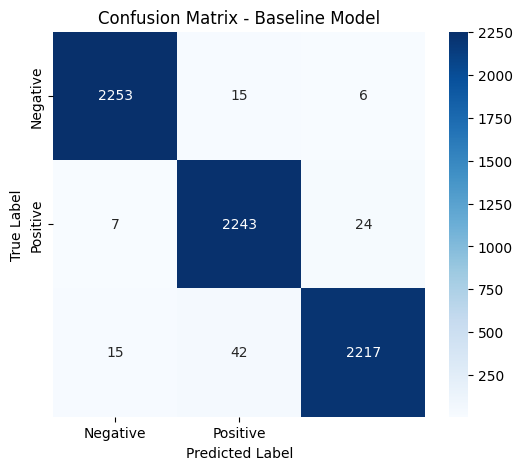

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# baseline model
y_true = baseline_metrics['y_true']
y_pred = baseline_metrics['y_pred']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Baseline Model")
plt.show()


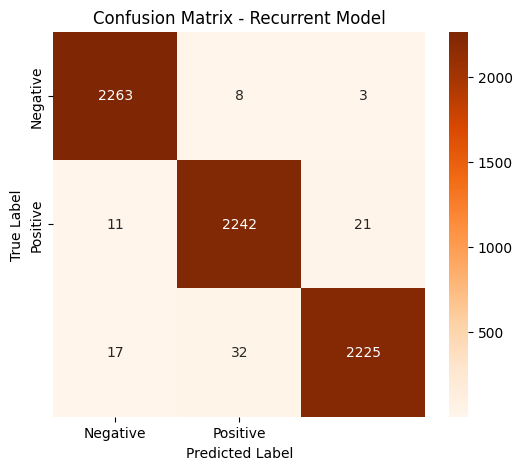

In [15]:
# recurrent model
y_true = recurrent_metrics['y_true']
y_pred = recurrent_metrics['y_pred']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Recurrent Model")
plt.show()